In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
%matplotlib inline
import json
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling1D,Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential,Model,Input

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


In [37]:
dir1 = "../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json"
dir2 = "../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json"

In [38]:
sens = []
labels = []
for line in open(dir1, 'r'):
    temp = []
    temp.append(json.loads(line))
    sens.append(temp[0]["headline"])
    labels.append(temp[0]["is_sarcastic"])
for line in open(dir2, 'r'):
    temp = []
    temp.append(json.loads(line))
    sens.append(temp[0]["headline"])
    labels.append(temp[0]["is_sarcastic"])
print("sens Length:",len(sens),"\nlabels Length:",len(labels))

sens Length: 55328 
labels Length: 55328


In [39]:
df = pd.DataFrame(columns = ["sens","labels"])
df["sens"] = np.array(sens)
df["labels"] = np.array(labels)

eda_tokenizer = Tokenizer(oov_token = "<OOV>")
word_index = eda_tokenizer.word_index

eda_tokenizer.fit_on_texts(sens)
sequences = eda_tokenizer.texts_to_sequences(sens)
pad_all = pad_sequences(sequences,padding = "post")

In [40]:
sp = np.array(pad_all)

In [41]:
df.head()

,sens,labels
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [42]:
df.isnull().sum()

sens      0
labels    0
dtype: int64

# EDA

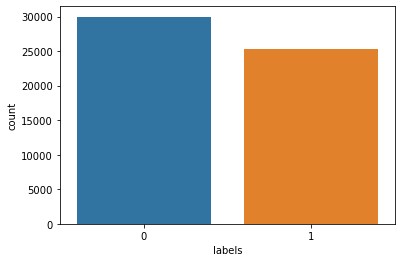

In [43]:
sns.countplot(x = "labels",data = df)

### Word clouds are an easy to use and inexpensive option for visualizing text data. One of the challenges of interpreting word clouds is that the display emphasizes frequency of words, not necessarily their importance.

In [44]:
ones = df.where(df["labels"] == 1).dropna().reset_index().drop(["index"],axis = 1)
zeros = df.where(df["labels"] == 0).dropna().reset_index().drop(["index"],axis = 1)
sens_train = []
sens_test = []
labels_train = []
labels_test = []
for data in [ones,zeros]:
    sens_train += list(data["sens"])[0:20000]
    sens_test += list(data["sens"])[20000:]
    labels_train += list(data["labels"])[0:20000]
    labels_test += list(data["labels"])[20000:]

print("Train Sentences Length:",len(sens_train),"\nTest Sentences Length:",len(sens_test))
print("Train Labels Length:",len(labels_train),"\nTest Labels Length:",len(labels_test))
                      
tokenizer = Tokenizer(oov_token = "<OOV>")
word_index = tokenizer.word_index

tokenizer.fit_on_texts(sens_train)
seq_train = tokenizer.texts_to_sequences(sens_train)
pad_train = pad_sequences(seq_train,padding = "post")

Train Sentences Length: 40000 
Test Sentences Length: 15328
Train Labels Length: 40000 
Test Labels Length: 15328


In [45]:
def plot_wordcloud(df):
    words = '' 
    stopwords = set(STOPWORDS) 

    # iterate through the csv file 
    for val in df.values: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (20,16), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

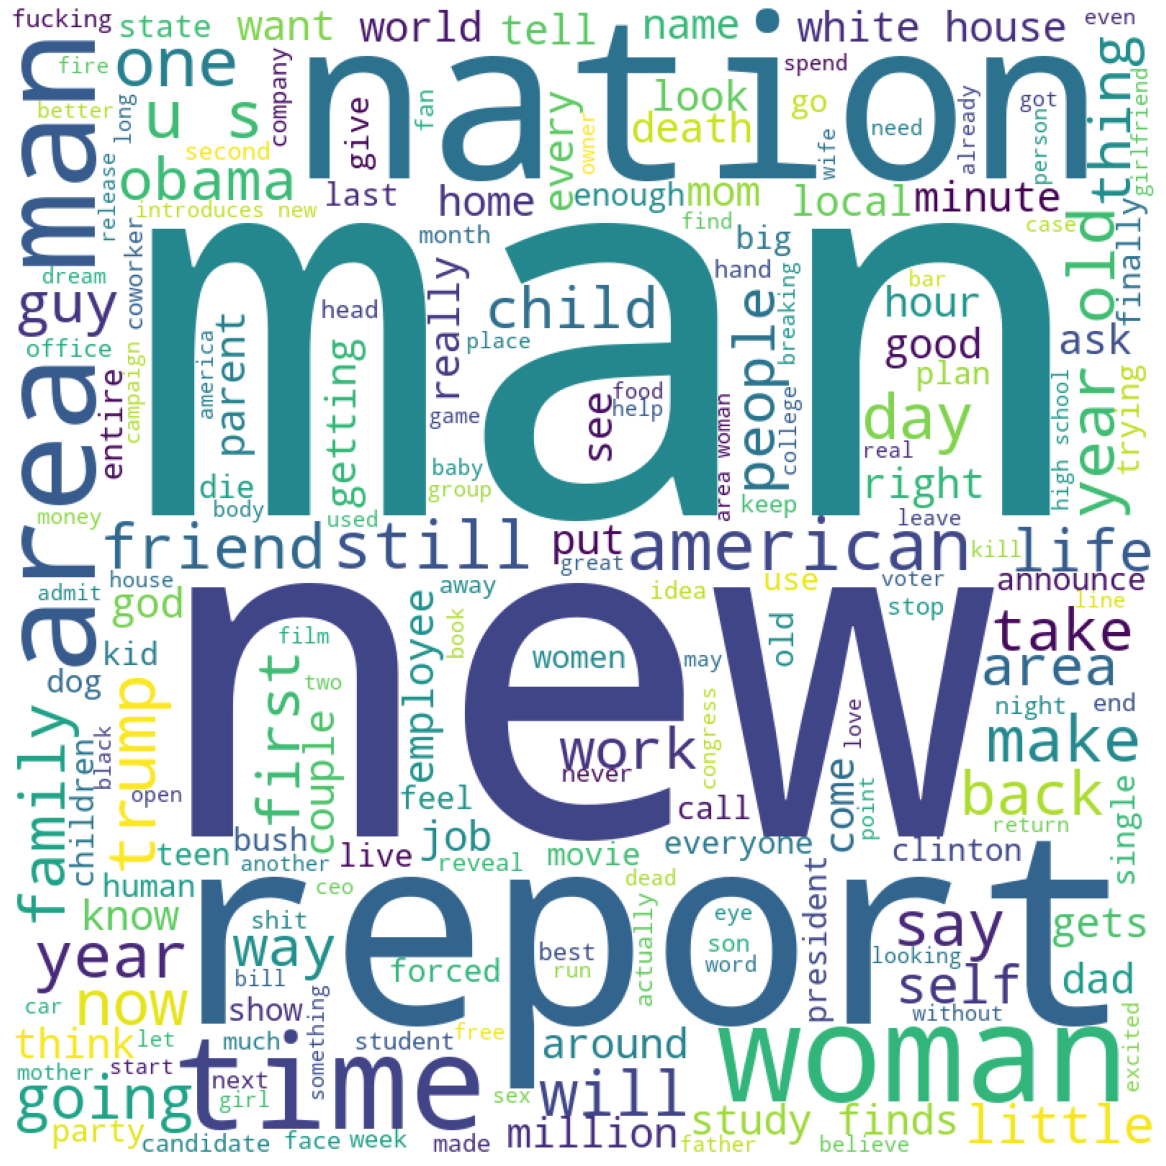

In [46]:
plot_wordcloud(ones["sens"])

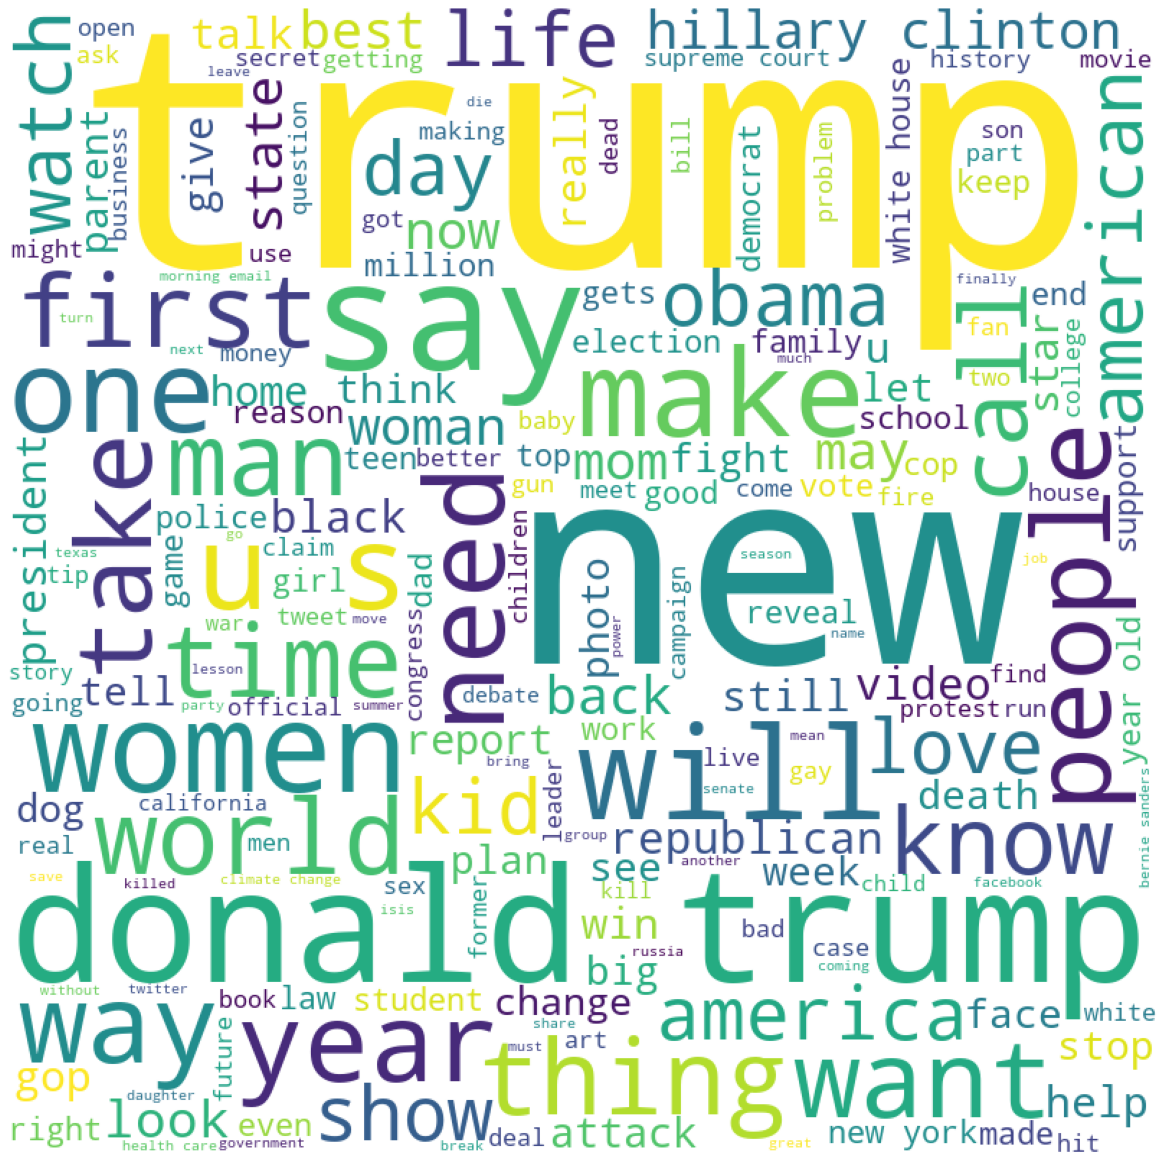

In [47]:
plot_wordcloud(zeros["sens"])

# Model

In [48]:
training_padded = np.array(pad_train)
training_labels = np.array(labels_train)

In [49]:
input_layer = Input(shape = (152,))
emb = Embedding(46708,125,input_length = 152)(input_layer)
gal = GlobalAveragePooling1D()(emb)
d1 = Dense(24,activation = "relu")(gal)
drop1 = tf.keras.layers.Dropout(0.2)(d1)
d2 = Dense(12,activation = "relu")(drop1)
drop2 = tf.keras.layers.Dropout(0.2)(d2)
d3 = Dense(1,activation = "sigmoid")(drop2)
model = Model(inputs = input_layer,outputs = d3)
model.compile(loss = "binary_crossentropy",optimizer = tf.keras.optimizers.Adam(lr = 0.001),metrics = ["accuracy"])
history = model.fit(training_padded,training_labels,validation_split = 0.2,shuffle = True,epochs = 10)

Epoch 1/10
1000/1000 [==============================] - 30s 30ms/step - loss: 0.5979 - accuracy: 0.6619 - val_loss: 0.7824 - val_accuracy: 0.7091
Epoch 2/10
1000/1000 [==============================] - 32s 32ms/step - loss: 0.3722 - accuracy: 0.8772 - val_loss: 0.6312 - val_accuracy: 0.8080
Epoch 3/10
1000/1000 [==============================] - 32s 32ms/step - loss: 0.2686 - accuracy: 0.9137 - val_loss: 0.5164 - val_accuracy: 0.8679
Epoch 4/10
1000/1000 [==============================] - 31s 31ms/step - loss: 0.2077 - accuracy: 0.9359 - val_loss: 0.4360 - val_accuracy: 0.9064
Epoch 5/10
1000/1000 [==============================] - 31s 31ms/step - loss: 0.1620 - accuracy: 0.9512 - val_loss: 0.4727 - val_accuracy: 0.9016
Epoch 6/10
1000/1000 [==============================] - 32s 32ms/step - loss: 0.1368 - accuracy: 0.9599 - val_loss: 0.4404 - val_accuracy: 0.9243
Epoch 7/10
1000/1000 [==============================] - 32s 32ms/step - loss: 0.1195 - accuracy: 0.9657 - val_loss: 0.5371 -

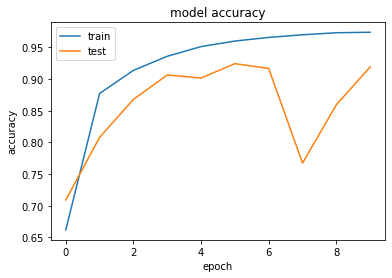

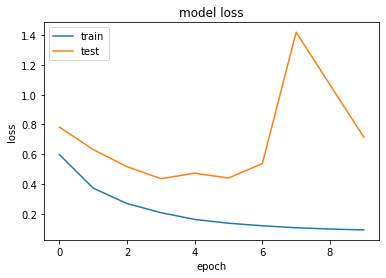

In [50]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evaluation

In [51]:
seq_test = tokenizer.texts_to_sequences(sens_test)
pad_test = pad_sequences(seq_test,padding = "post")
test_padded = np.array(pad_test)
test_labels = np.array(labels_test)

In [52]:
model.evaluate(test_padded,test_labels)

479/479 [==============================] - 1s 1ms/step - loss: 1.3625 - accuracy: 0.9230


[1.3625434637069702, 0.9230167269706726]

In [53]:
sentence = ["I am extremely grateful to you","I am grateful to you"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences)
print(model.predict(padded))

[[1.        ]
 [0.00606588]]


In [54]:
def get_results(sen):
    sequences = tokenizer.texts_to_sequences(sen)
    padded = pad_sequences(sequences)
    pred = model.predict(padded)
    if pred[0][0] < 0.7:
        print("\"" + sen + "\"" + " is not sarcastic " + str(100 - pred[0][0]*100) + "%")
    else:
        print("\"" + sen + "\"" + " is sarcastic " + str(pred[0][0]*100) + "%")

In [55]:
get_results("I am alright")

"I am alright" is not sarcastic 99.9999989500865%


In [56]:
get_results("We are happy")

"We are happy" is not sarcastic 99.9999994116223%


In [57]:
get_results("Are you alright?") 

"Are you alright?" is not sarcastic 99.9999998957868%


In [58]:
get_results("You are very very nice")

"You are very very nice" is sarcastic 100.0%


In [59]:
get_results("You look soooo beautiful")

"You look soooo beautiful" is sarcastic 100.0%


In [60]:
get_results("cats hate dogs")

"cats hate dogs" is not sarcastic 99.9549388885498%


In [61]:
get_results("You are perfect")

"You are perfect" is sarcastic 100.0%


The sarcasm analyser is not perfect since it is unable to read the data based on context. For this RNN's using LSTM will be a good match.